# Creating an numba-compatible sorted array intersection algorithm
In order to apply just in time compilation with numba to a function, all functions that are called in that funcion must also be compatible with numba.

`sortednp.intersect` is one example of a non-compatible function which is used in the core of the greedysearch algorithm that we aim to convert to be numba-compatible. This notebook aims to propose and test a numba-compatible (specifically nopython mode) algoritm with performance as close to `sortednp.intersect` as possible. 

In [65]:
import sortednp as snp
import numpy as np
from numba import njit
from numba.typed import List

@njit
def intersect_sorted_array(A, B):
  """
  Returns the sorted intersection of A and B
  - Assumes A and B are sorted
  - Assumes A and B each have no duplicates
  """
  i = 0
  j = 0
  intersection = List()

  while i < len(A) and j < len(B):
      if A[i] == B[j]:
          intersection.append(A[i])
          i += 1
          j += 1
      elif A[i] < B[j]:
          i += 1
      else:
          j += 1
  return intersection

def snp_intersect(A, B):
  return snp.intersect(A, B)

In [85]:
# from timeit import repeat, timeit
from math import floor, log, log10, sqrt
import timeit

from matplotlib import test

benchmarks_balanced = {
  'intersect_sorted_array': {},
  'snp_intersect': {}
}

benchmarks_unbalanced = {
  'intersect_sorted_array': {},
  'snp_intersect': {}
}

benchmarks_sqrt = {
  'intersect_sorted_array': {},
  'snp_intersect': {}
}

benchmarks_density = {
  'intersect_sorted_array': {},
  'snp_intersect': {}
}

ns_to_plot = range(0, 100000, 10000)
densities_to_plot = [1/(x**2) for x in range(1, 6, 1)]

NUM_REPEATS = 5
RUNS_PER_REPEAT = 7
BASE_N = ns_to_plot[-1]
BASE_DENSITY = 1/3

RNG = np.random.default_rng(0)

def generate_test_data(number_to_generate, density):
  # Unique, because extents are unique
  return np.sort(RNG.choice(number_to_generate*round(1/density), number_to_generate, replace=False))

test_A = generate_test_data(100, BASE_DENSITY)
test_B = generate_test_data(100, BASE_DENSITY)
# Run all functions first to eliminate the effect of compilation
intersect_sorted_array(test_A, test_B)
snp_intersect(test_A, test_B)

print('benchmarks_balanced:')
for n in ns_to_plot:
  for method in ['intersect_sorted_array', 'snp_intersect']:
    print(f'n={n}, method={method}:')
    # Yes, I know this is evil
    timeresults = []
    for i in range(NUM_REPEATS):
      test_A = generate_test_data(n, BASE_DENSITY)
      test_B = generate_test_data(n, BASE_DENSITY)
      timeresults.append(min(timeit.repeat(f'{method}(test_A, test_B)', repeat=RUNS_PER_REPEAT, number=300, globals=globals())))
    benchmarks_balanced[method][n] = timeresults

print('benchmarks_unbalanced:')
for n in ns_to_plot:
  for method in ['intersect_sorted_array', 'snp_intersect']:
    print(f'n={n}, method={method}:')
    # Yes, I know this is evil
    timeresults = []
    for i in range(NUM_REPEATS):
      test_A = generate_test_data(20, BASE_DENSITY)
      test_B = generate_test_data(n, BASE_DENSITY)
      timeresults.append(min(timeit.repeat(f'{method}(test_A, test_B)', repeat=RUNS_PER_REPEAT, number=300, globals=globals())))
    benchmarks_unbalanced[method][n] = timeresults
    
print('benchmarks_sqrt:')
for n in ns_to_plot:
  for method in ['intersect_sorted_array', 'snp_intersect']:
    print(f'n={n}, method={method}:')
    # Yes, I know this is evil
    timeresults = []
    for i in range(NUM_REPEATS):
      test_A = generate_test_data(floor(sqrt(n)), BASE_DENSITY)
      test_B = generate_test_data(n, BASE_DENSITY)
      timeresults.append(min(timeit.repeat(f'{method}(test_A, test_B)', repeat=RUNS_PER_REPEAT, number=300, globals=globals())))
    benchmarks_sqrt[method][n] = timeresults
    
print('benchmarks_density:')
for density in densities_to_plot:
  for method in ['intersect_sorted_array', 'snp_intersect']:
    print(f'density={density}, method={method}:')
    # Yes, I know this is evil
    timeresults = []
    for i in range(NUM_REPEATS):
      test_A = generate_test_data(BASE_N, density)
      test_B = generate_test_data(BASE_N, density)
      timeresults.append(min(timeit.repeat(f'{method}(test_A, test_B)', repeat=RUNS_PER_REPEAT, number=300, globals=globals())))
    benchmarks_density[method][density] = timeresults

benchmarks_balanced:
n=0, method=intersect_sorted_array:
n=0, method=snp_intersect:
n=10000, method=intersect_sorted_array:
n=10000, method=snp_intersect:
n=20000, method=intersect_sorted_array:
n=20000, method=snp_intersect:
n=30000, method=intersect_sorted_array:
n=30000, method=snp_intersect:
n=40000, method=intersect_sorted_array:
n=40000, method=snp_intersect:
n=50000, method=intersect_sorted_array:
n=50000, method=snp_intersect:
n=60000, method=intersect_sorted_array:
n=60000, method=snp_intersect:
n=70000, method=intersect_sorted_array:
n=70000, method=snp_intersect:
n=80000, method=intersect_sorted_array:
n=80000, method=snp_intersect:
n=90000, method=intersect_sorted_array:
n=90000, method=snp_intersect:
benchmarks_unbalanced:
n=0, method=intersect_sorted_array:
n=0, method=snp_intersect:
n=10000, method=intersect_sorted_array:
n=10000, method=snp_intersect:
n=20000, method=intersect_sorted_array:
n=20000, method=snp_intersect:
n=30000, method=intersect_sorted_array:
n=30000, 

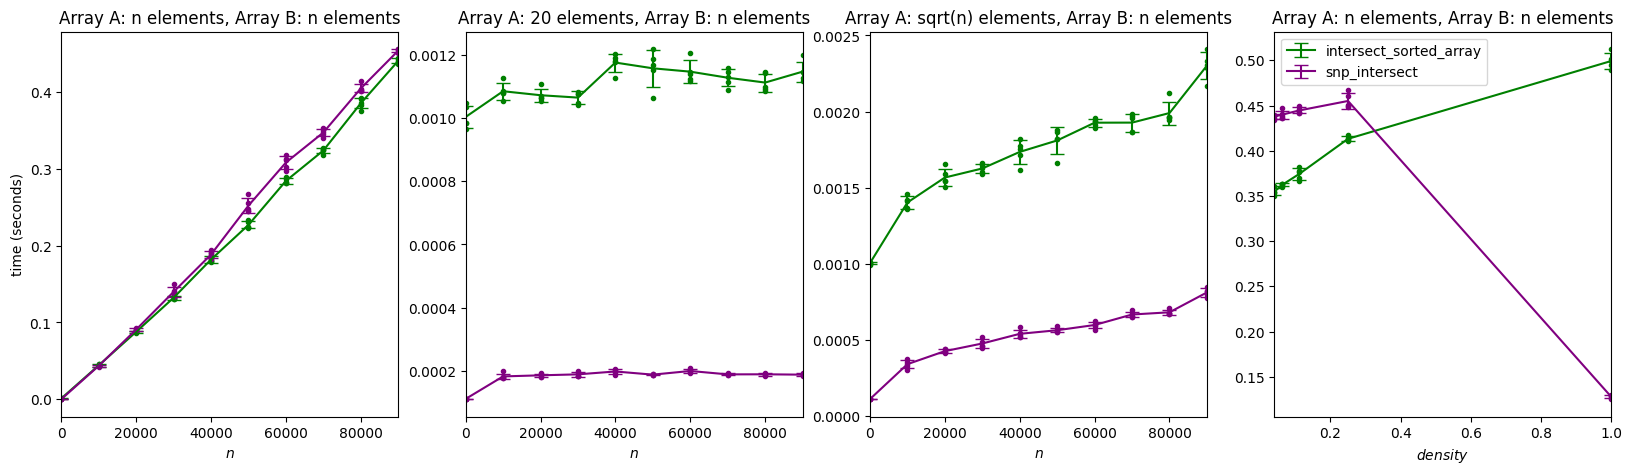

In [88]:
from statistics import mean, stdev
from matplotlib.markers import MarkerStyle
import matplotlib.pyplot as plt
from numpy import average
label_to_colors = {
  'intersect_sorted_array': 'green',
  'snp_intersect': 'purple'
}
plt.subplots(1, 4, figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.xlim(ns_to_plot[0], ns_to_plot[-1])
plt.title('Array A: n elements, Array B: n elements')
plt.xlabel('$n$ (density = 1/3)')
plt.ylabel('time (seconds)')
for label, time_result in benchmarks_balanced.items():
  for n in ns_to_plot:
    plt.scatter([n]*NUM_REPEATS, time_result[n], c=label_to_colors[label], marker='.')
  plt.errorbar(ns_to_plot, [mean(time_result[n]) for n in ns_to_plot], yerr=[stdev(time_result[n]) for n in ns_to_plot], marker='', capsize=5.0, label=label, c=label_to_colors[label])

plt.subplot(1, 4, 2)
plt.xlim(ns_to_plot[0], ns_to_plot[-1])
plt.title('Array A: 20 elements, Array B: n elements')
plt.xlabel('$n$ (density = 1/3)')
for label, time_result in benchmarks_unbalanced.items():
  for n in ns_to_plot:
    plt.scatter([n]*NUM_REPEATS, time_result[n], c=label_to_colors[label], marker='.')
  plt.errorbar(ns_to_plot, [mean(time_result[n]) for n in ns_to_plot], yerr=[stdev(time_result[n]) for n in ns_to_plot], marker='', capsize=5.0, label=label, c=label_to_colors[label])

plt.subplot(1, 4, 3)
plt.xlim(ns_to_plot[0], ns_to_plot[-1])
plt.title('Array A: sqrt(n) elements, Array B: n elements')
plt.xlabel('$n$ (density = 1/3)')
for label, time_result in benchmarks_sqrt.items():
  for n in ns_to_plot:
    plt.scatter([n]*NUM_REPEATS, time_result[n], c=label_to_colors[label], marker='.')
  plt.errorbar(ns_to_plot, [mean(time_result[n]) for n in ns_to_plot], yerr=[stdev(time_result[n]) for n in ns_to_plot], marker='', capsize=5.0, label=label, c=label_to_colors[label])

plt.subplot(1, 4, 4)
plt.xlim(densities_to_plot[-1], densities_to_plot[0])
plt.title('Array A: n elements, Array B: n elements')
plt.xlabel('$density$ (n=90,000)')
for label, time_result in benchmarks_density.items():
  for n in densities_to_plot:
    plt.scatter([n]*NUM_REPEATS, time_result[n], c=label_to_colors[label], marker='.')
  plt.errorbar(densities_to_plot, [mean(time_result[n]) for n in densities_to_plot], yerr=[stdev(time_result[n]) for n in densities_to_plot], marker='', capsize=5.0, label=label, c=label_to_colors[label])
plt.legend()

plt.show()